In [ ]:
# Importing Important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv("data.csv")
df.head()

,Warehouse id,Region,SKU id,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,...,Aug-20,Sep-20,Oct-20,Nov-20,Dec-20,Jan-21,Feb-21,Mar-21,Apr-21,May-21
0,Wh-1,NORTH,SKU-1,27,13,30,14,22,8,8,...,12,8,8,8,8,8,14,16,8,12
1,Wh-1,NORTH,SKU-2,88,28,127,130,58,10,7,...,16,7,7,7,7,7,13,43,13,43
2,Wh-1,NORTH,SKU-3,6,6,6,6,6,6,6,...,8,6,6,6,6,6,6,8,26,6
3,Wh-1,NORTH,SKU-4,162,184,110,172,90,40,18,...,82,78,38,18,22,28,36,352,58,18
4,Wh-1,NORTH,SKU-5,171,402,627,615,300,417,141,...,468,216,75,6,30,66,141,699,183,24


In [ ]:
df.columns = df.columns.str.replace('[-]', '', regex=True)
df.head()

,Warehouse id,Region,SKU id,Apr18,May18,Jun18,Jul18,Aug18,Sep18,Oct18,...,Aug20,Sep20,Oct20,Nov20,Dec20,Jan21,Feb21,Mar21,Apr21,May21
0,Wh-1,NORTH,SKU-1,27,13,30,14,22,8,8,...,12,8,8,8,8,8,14,16,8,12
1,Wh-1,NORTH,SKU-2,88,28,127,130,58,10,7,...,16,7,7,7,7,7,13,43,13,43
2,Wh-1,NORTH,SKU-3,6,6,6,6,6,6,6,...,8,6,6,6,6,6,6,8,26,6
3,Wh-1,NORTH,SKU-4,162,184,110,172,90,40,18,...,82,78,38,18,22,28,36,352,58,18
4,Wh-1,NORTH,SKU-5,171,402,627,615,300,417,141,...,468,216,75,6,30,66,141,699,183,24


After feature engineering we narrow down to below observations.  
The significant factors seem to be:   
1. Region  
2. April 2021 (most important)  
3. September 2020  
4. October 2020  
5. October 2019  

In [ ]:
# Univariate LSTM
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# define model
def fit_LSTM_model(X_train, y_train, epochs, neurons):
  model = Sequential()
  model.add(LSTM(neurons, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(X_train, y_train, epochs=epochs, verbose=0)
  return model

In [ ]:
from sklearn.metrics import *
def get_LSTM_accuracy(model, X, Y, n_steps, n_features):
  y_pred = []
  for i in range(len(X)):
    x = X[i].reshape((1, n_steps, n_features))
    y = model.predict(x, verbose=0)
    y_pred.append(y.copy()[0][0])

  print("Predicted: ", y_pred)
  print("Actual: ", Y)

  print("Mean absolute error =", round(mean_absolute_error(Y, y_pred), 2)) 
  print("Mean squared error =", round(mean_squared_error(Y, y_pred), 2)) 
  print("Median absolute error =", round(median_absolute_error(Y, y_pred), 2)) 
  print("Explain variance score =", round(explained_variance_score(Y, y_pred), 2)) 
  print("R2 score =", round(r2_score(Y, y_pred), 2))

  data_plot = pd.DataFrame({"Time": range(Y.shape[0]), "Predict": y_pred, "Actual": Y})
  sns.lineplot(x = "Time", y = "Actual", data=data_plot)
  sns.lineplot(x = "Time", y = "Predict", data=data_plot)
  plt.show()

In [ ]:
def train_LSTM_model(time_series, epochs, neurons, n_steps, n_features, percentage_train):
  X, y = split_sequence(time_series, n_steps)

  print("X: ", X.shape)
  print("Y: ", y.shape)

  X_train, y_train, X_test, y_test = X[0:int(percentage_train*X.shape[0])], y[0:int(percentage_train*X.shape[0])], X[int(percentage_train*X.shape[0]):], y[int(percentage_train*X.shape[0]):]
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

  print("X_train: ", X_train.shape)
  print("y_train: ", y_train.shape)
  print("X_test: ", X_test.shape)
  print("y_test: ", y_test.shape)

  LSTM_model = fit_LSTM_model(X_train, y_train, epochs, neurons)

  return X_train, y_train, X_test, y_test, LSTM_model

In [ ]:
time_df = df.drop(['Warehouse id', 'Region', 'SKU id'], axis = 1)
time_pd_series = time_df.sum()
time_series = time_pd_series.to_numpy()

In [ ]:
n_steps = 1
n_features = 1
percentage_train = 0.8
epochs = 500
neurons = 50

In [ ]:
X_train, y_train, X_test, y_test, LSTM_model = train_LSTM_model(time_series, epochs, neurons, n_steps, n_features, percentage_train)

X:  (37, 1)
Y:  (37,)
X_train:  (29, 1, 1)
y_train:  (29,)
X_test:  (8, 1, 1)
y_test:  (8,)


Predicted:  [240215.77, 209932.08, 202505.12, 152700.78, 169324.3, 153485.4, 156579.19, 195369.86, 205292.34, 171572.88, 140580.03, 372327.9, 274957.5, 254149.9, 244776.33, 167487.58, 182197.06, 171604.56, 156579.19, 221226.27, 261297.33, 236195.7, 258201.67, 189915.66, 14006.9375, 173698.45, 195621.47, 166086.06, 206555.02]
Actual:  [225281 217311 163865 181704 164707 168027 209654 220302 184117 150858
 399551 295061 272732 262673 179733 195518 184151 168027 237401 280402
 253465 277080 203801  15030 186398 209924 178229 221657 215886]
Mean absolute error = 47707.46
Mean squared error = 5694039650.39
Median absolute error = 28030.42
Explain variance score = -0.37
R2 score = -0.42


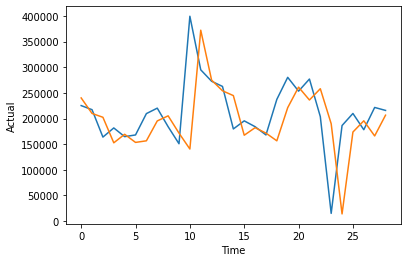

In [ ]:
get_LSTM_accuracy(LSTM_model, X_train, y_train, n_steps, n_features)

Predicted:  [201177.23, 231186.94, 250032.02, 376107.53, 265868.1, 266374.1, 375381.62, 146061.27]
Actual:  [248090 268313 403607 285307 285850 402828 156740 126886]
Mean absolute error = 90333.38
Mean squared error = 12824995062.39
Median absolute error = 68856.65
Explain variance score = -0.46
R2 score = -0.47


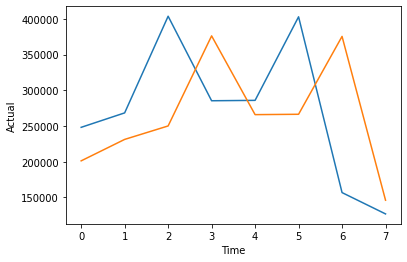

In [ ]:
get_LSTM_accuracy(LSTM_model, X_test, y_test, n_steps, n_features)